# Logistic regression using `scikit-learn`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm, metrics, model_selection as ms, preprocessing
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
var_names = [
    'age',
    'sex',
    'total_bilirubin',
    'direct_bilirubin',
    'alp',  # Alkaline phosphatase
    'alt',  # Alanine transaminase
    'ast',  # Aspartate transaminase
    'total_protein',
    'albumin',
    'ag_ratio',  # Albumin/globulin ratio
    'liver_disease'
]

Read in the [Indian Liver Patient Dataset (ILPD)](https://archive.ics.uci.edu/ml/datasets/ILPD+%28Indian+Liver+Patient+Dataset%29).

In [3]:
ilpd = pd.read_csv('datasets/ilpd.csv', header=None, names=var_names)

Convert `liver_disease` so that `1` corresponds to liver disease and `0` to no disease.

In [4]:
ilpd['liver_disease'] = (ilpd['liver_disease'] == 1).astype(int)

Remove observations with missing `ag_ratio`.

In [5]:
ilpd.dropna(inplace=True)

Prepare data for modelling.

In [6]:
X = pd.get_dummies(ilpd, columns=['sex']).drop(columns=['sex_Male', 'liver_disease']).astype(np.float64)
y = ilpd['liver_disease']

In [7]:
X.head()

,age,total_bilirubin,direct_bilirubin,alp,alt,ast,total_protein,albumin,ag_ratio,sex_Female
0,65.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1.0
1,62.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,0.0
2,62.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,0.0
3,58.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,0.0
4,72.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,0.0


## Logistic regression

Fit the model.

*Note*: by default, `scikit-learn` uses $L_{2}$ regularisation with parameter `C` (default = 1). This cannot be disabled, but we can set `C` so big that it has little effect.

In [8]:
model1 = lm.LogisticRegression(C=1e50, solver='liblinear')
model1.fit(X, y)

# C: is opposite of alpha >> set C = 1e50, it is large, meaning it's almost disabled

LogisticRegression(C=1e+50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Print regression coefficients.

In [9]:
model1.intercept_[0]

-2.830429221594966

In [10]:
list(zip(X.columns, model1.coef_[0, :]))

[('age', 0.017565516368645777),
 ('total_bilirubin', 0.0046981905802779425),
 ('direct_bilirubin', 0.4721143847409851),
 ('alp', 0.0012002044844354328),
 ('alt', 0.011369589856193761),
 ('ast', 0.0026303077554732743),
 ('total_protein', 0.7135812335408238),
 ('albumin', -1.2914029979899488),
 ('ag_ratio', 1.1998550128838863),
 ('sex_Female', -0.04053839045328717)]

Print odds ratios.

In [11]:
np.exp(model1.intercept_[0])

0.05898752951349844

In [12]:
list(zip(X.columns, np.exp(model1.coef_[0, :])))

[('age', 1.017720697330965),
 ('total_bilirubin', 1.004709244381818),
 ('direct_bilirubin', 1.6033807755324718),
 ('alp', 1.0012009250180713),
 ('alt', 1.0114344692939987),
 ('ast', 1.0026337700498853),
 ('total_protein', 2.041288515154757),
 ('albumin', 0.27488484952969633),
 ('ag_ratio', 3.3196355834536),
 ('sex_Female', 0.9602722985149472)]

Compute classification accuracy.

In [13]:
metrics.accuracy_score(y, model1.predict(X))

0.7409326424870466

Compute confusion matrix.

In [14]:
metrics.confusion_matrix(y, model1.predict(X))

array([[ 44, 121],
       [ 29, 385]], dtype=int64)

In [15]:
pd.crosstab(y, model1.predict(X), margins = True)
#another way to see confusion matrix

col_0,0,1,All
liver_disease,,,
0,44,121,165
1,29,385,414
All,73,506,579


## ROC analysis

Compute predicted probabilities for liver disease (`y` = 1).

In [16]:
pred_probs = model1.predict_proba(X)[:, 1]
#predict_proba give the prediction probability

In [17]:
model1.predict_proba(X)

array([[0.39041209, 0.60958791],
       [0.0078189 , 0.9921811 ],
       [0.02991439, 0.97008561],
       ...,
       [0.31343264, 0.68656736],
       [0.43722563, 0.56277437],
       [0.53213609, 0.46786391]])

Visualise distribution.

C:\Users\Phoenix\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


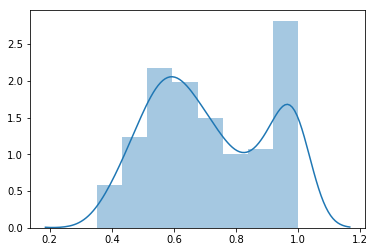

In [18]:
sns.distplot(pred_probs)

Define a set of cut-off values where sensitivity and specificity will be computed.

In [19]:
cutoffs = np.linspace(0, 1, 1001)

In [20]:
cutoffs

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

Define a function to compute specificity.

In [21]:
def specificity_score(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

Compute sensitivity and specificity at the cut-off values defined above.

In [22]:
# this for understanding, no need to create a cut off

In [23]:
sensitivities = np.zeros(cutoffs.size)
specificities = np.zeros(cutoffs.size)
for i, cutoff in enumerate(cutoffs):
    sensitivities[i] = metrics.recall_score(y, pred_probs >= cutoff)
    specificities[i] = specificity_score(y, pred_probs >= cutoff)

Plot the ROC curve, i.e. sensitivity versus (1 - specificity).

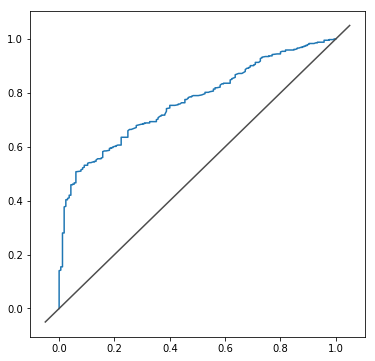

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(1 - specificities, sensitivities)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c=".3")

Alternatively…

(FPR = 1 - specificity; TPR = sensitivity)

In [25]:
fpr, tpr, cutoffs = metrics.roc_curve(y, pred_probs)

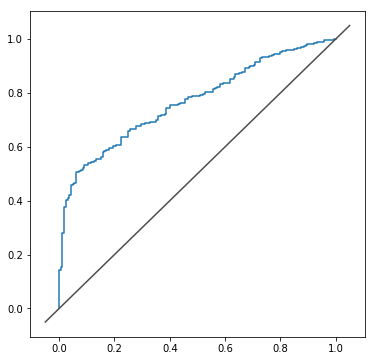

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c=".3")

Compute area under the ROC curve (AUC).

In [27]:
metrics.roc_auc_score(y, pred_probs)

0.7669594495681452

## Cross-validation

Define stratified folds.

In [28]:
cv = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Compute average classification accuracy across folds.

In [29]:
accuracies = ms.cross_val_score(model1, X, y, scoring='accuracy', cv=cv)
np.mean(accuracies)

0.7185457271364318

Compute average AUC across folds.

In [30]:
aucs = ms.cross_val_score(model1, X, y, scoring='roc_auc', cv=cv)
np.mean(aucs)

0.745881975796757

## Regularisation

Define a pipeline to scale the data and estimate a regularised logistic regression model (`scikit-learn` uses $L_{2}$ regularisation by default).

In [31]:
scaled_logreg = Pipeline([
    ('std', preprocessing.StandardScaler()),
    ('reg', lm.LogisticRegression(solver='liblinear'))
])

Determine 'optimal' value of `C` by cross-validation using AUC scoring.

In [32]:
gs = ms.GridSearchCV(estimator=scaled_logreg,
                     param_grid={'reg__C': np.logspace(-5, 5, 11)},
                     scoring='roc_auc',
                     cv=cv)
gs.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'reg__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [33]:
gs.best_score_

0.7516979828754413

In [34]:
gs.best_estimator_.named_steps['reg']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Plot `C`s against AUC scores.

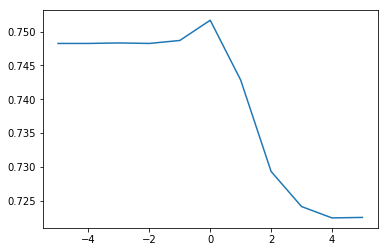

In [35]:
plt.plot(-np.log10(gs.param_grid['reg__C']), gs.cv_results_['mean_test_score'])